# Using Differential Privacy for Privacy-preserving Statistical Releases on Synthetic Suvery Data

<img src="images/researchers.jpeg" width=1000 />

This notebook is aimed at demonstrating how to generate and release basic statistical outcomes in differentially private manner. 

Let's assume NRF has requested A\*STAR for the following statistics (queries): 
- Count of researchers 
- Sum of researchers' income 
- Mean of researchers' income 
- Count of researchers by sector
- Count of researchers by sector and academic degree

A\*STAR values the privacy of their survey participants, so they want to make sure that the data they release does not reveal anything about specific people. This is a perfect use case for differential privacy: it will allow us to publish useful insights about groups, while protecting data about individuals.

The noise added to the computation of a query can depend on the privacy parameters, the type of query, and the data itself. But in many cases, the result will still convey accurate insights about the original data. We wil learn the impact of:  
1. **Epsilon(ε)**: The privacy loss incurred by researchers in the dataset. Larger values indicate less privacy and more accuracy.
2. **Sensitivity**: The worst case change in a query's output when a row is removed/added. Noise scales with the sensitivity of a query.
3. **Clamping bounds**: Clipping the raw values to the set lower and upper bounds. Noise scales with the size of the bounds
4. **Dataset size**: Noise cancels out with larger dataset size hence better accuracy. 

With the above queries we will also be introduced to the concepts of **parallel composition** and **post-processing**.  

### Contents 

1. [Overview of Differential Private Mechanisms](#cell1)
    * 1.1. [Laplacian mechanism](#cell11)
    * 1.2. [Gaussian mechanism ](#cell12)
2. [Utility Functions](#cell2)
3. [Computing Queries Using Differential Privacy](#cell3)
    * 3.1. [Synthetic survey data](#cell31)
    * 3.2. [Count of researchers](#cell32)
        * 3.2.1. [Impact of epsilon](#cell321)
    * 3.3. [Sum of researchers' income](#cell33)
        * 3.3.1. [Impact of epsilon](#cell331)
        * 3.3.2. [Impact of clamping bounds](#cell332)
    * 3.4. [Mean of researchers' income (with post-processing)](#cell34)
    * 3.5. [Count of researchers by sector (with parallel composition)](#cell35)
    * 3.6. [Count of researchers by sector and academic degree (with parallel composition)](#cell36)
4. [Impact of Dataset Size](#cell4)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Overview of Differential Private Mechanisms <a id="cell1"></a>

### 1.1. Laplace mechanism <a id="cell11"></a>

For a function ${f}(x)$ that output's a number for a query, **laplace mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + Lap(\frac{s}{\epsilon}$)

where **$s$** denotes sensitivtity and **$Lap(\frac{s}{\epsilon})$** denotes sampling a random value from the [laplacian distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with center 0 and scale $\frac{s}{\epsilon}$.

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$).

The laplacian mechanism satisfies the **$\epsilon$-differential privacy** i.e. pure-differential privacy, meaning, it provides worst case privacy gaurantee to the individuals in the dataset. 

In [2]:
def laplace_mechanism(query, sensitivity, epsilon):
    return query + round(np.random.laplace(loc=0, scale=sensitivity/epsilon), 2)

### 1.2. Gaussian mechanism <a id="cell12"></a>

For a function ${f}(x)$ that output's a number for a query, **gaussian mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + \mathcal{N}(\sigma^{2})$

where $\sigma^{2} = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$

$\mathcal{N}(\sigma^{2})$ denotes sampling a random value from the [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with center 0 and scale **$\sigma^{2}$**. 

$s$ is sensitivity  

𝛿 is the failue probability 
- with probability 1−𝛿, we will get the same guarantee as pure differential privacy;
- with probability 𝛿, we get no guarantee 

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$) and delta ($\delta$).

The gaussian mechanism satisfies the **$(\epsilon, \delta)$-differential privacy** i.e. approximate-differential privacy, meaning, it provides relaxed privacy gaurantee. 

In [3]:
def gaussian_mechanism(query, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return query + np.random.normal(loc=0, scale=sigma)

## 2. Utility Functions <a id="cell2"></a>

In [4]:
# function we will use to compute percentage absolute error 
def percentage_error(true_value, private_value):
    return round(abs(true_value - private_value)/true_value*100, 2)

In [5]:
# constants for the visualisations 
colors = ["#4CB7A5", "#0198E1", "#DE3163"]

# function we will use to visualise the impact of sensitivity, epsilon, bounds and dataset size 
# on the accuracy of a query output
def visualise(dp_results, param, param_values, errors, ylabel, title, labels, figsize=(10, 6)):
    dp_results = pd.DataFrame(dp_results, index=labels)
    
    legend_labels = ['True value']
    for param_value, error in zip(param_values, errors):
        legend_labels.append(f"{param} = {str(param_value)} : Error = {str(round(error, 1))}%")

    ax = dp_results.plot.bar(rot=0, figsize=figsize, width=0.8, fontsize=12, colormap = "Wistia")
    
    plt.title(title, fontsize=16)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(ylabel, fontsize = 14)
    plt.legend(fontsize = 12, labels=legend_labels)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## 3. Computing Queries Using Differential Privacy <a id="cell3"></a>

### 3.1. Synthetic survey data <a id="cell31"></a>

Now, we need to load our dataset, containing information about the researchers 

In [6]:
# reading the csv file 
data = pd.read_csv("data/simulated_data_500.csv")
data_size = len(data)

print(f"Number of rows in the dataset {data_size}")
data.head(20)

Number of rows in the dataset 500


,NRIC,researcher_name,sector,income,degree
0,F7582445S,Richard Westfall,Aerospace,6527,Post-grad
1,F6351848Q,Brenda Tonn,Healthcare,8383,Non-degree
2,F0543228O,Juanita Cornwell,Agricultural,8298,Masters
3,G2869872L,Mary Lagasca,Engineering,3763,PhD
4,T0323244I,Frederick Patrick,Aerospace,13694,Masters
5,S8542460T,Paul Engler,Agricultural,3222,Masters
6,T3274897X,Frances Kinsler,Healthcare,4095,PhD
7,S8801177R,Leticia Fox,Healthcare,5191,Non-degree
8,S3833675A,Jose Higa,Healthcare,7598,Masters
9,G9347179L,Lionel Daily,Healthcare,5310,Masters


Great! Our dataset is ready for analysis. 

### 3.2. Count of researchers <a id="cell32"></a>

We will count the researchers in the dataset who participated in the survey. We will also assume each researcher contributes to atmost one row. 

##### True count

In [7]:
# count of researchers is the number of rows
true_count = len(data['researcher_name'])

print("+----------------------------------+")
print(f"True count of the researchers: {true_count}")
print("+----------------------------------+")

+----------------------------------+
True count of the researchers: 500
+----------------------------------+


##### Private count 

We now allocate epsilon = 0.1 to count the researchers in a differentially private manner.   

As a rule of thumb, sensitivity of **count** query is 1. 

In [8]:
sensitivity = 1 

# you can play around with the epsilon value here
epsilon = 0.1

# applying laplacian mechanism
private_count = laplace_mechanism(true_count, sensitivity, epsilon)

print("+-------------------------------------------------------------------+")
print(f"Private count of the researchers: {private_count} with error: {percentage_error(true_count, private_count)}%")
print("+-------------------------------------------------------------------+")

+-------------------------------------------------------------------+
Private count of the researchers: 534.23 with error: 6.85%
+-------------------------------------------------------------------+


**Everytime you run the above lines of code, you might see different values! This is a central characteristic of differential privacy: it injects some randomisation (we call this noise) in the execution of the query.** 

#### 3.2.1. Impact of epsilon <a id="cell321"></a>

Now, we will visualise error with different values of epsilon. 

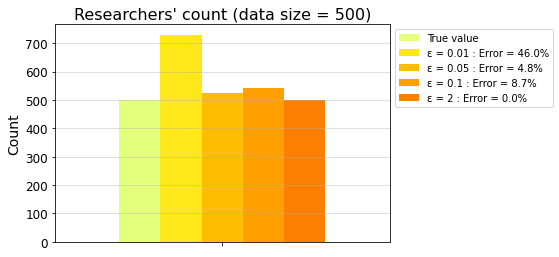

In [9]:
sensitivity = 1 

# you can play around with the epsilon values here 
epsilons = [0.01, 0.05, 0.1, 2]

# for visualisation
errors = []
dp_results = {}
dp_results["true_count"] = [true_count]

# evaluating on different values of epsilon
for epsilon in epsilons:
    # adding laplacian noise
    private_count = laplace_mechanism(true_count, sensitivity, epsilon)
    
    dp_results[f"epsilon_{epsilon}"] = [private_count]
    errors.append(percentage_error(true_count, private_count))

# visualise data 
labels = [""]
title = f"Researchers' count (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (6, 4))

### 3.3. Sum of researchers' income <a id="cell33"></a>

Counting query, which we ran is very useful, but we often need a little more: sums, averages, medians… We will see how to compute this larger class of aggregations with differential privacy. These operations require us to learn and use a new concept: **clamping bounds.** 

Sometimes we known a reasonable minimum and maximum for each value of a column, you can use those as clamping bounds e.g., age can have lower bound of 0 and an upper bound of 120.  It is simple to assume, without looking at the dataset, that all of the researchers in the survey are under the age of 120 and that ages must have a positive value.

Sometimes, things are not as clear-cut. Let's first explain what these clamping bounds do in order to understand what to do in more complicated situations.

#### Clamping bounds 
The data is clamped to be within minimum and maximum bounds in order to limit
the influence any one individual has on the query. 

$ f_{clamping}(x)= 
\begin{cases}
    upper,& \text{if } x\gt upper\\
    lower,& \text{if } x\lt lower\\
    x,              & \text{otherwise}
\end{cases}$

If these bounds are too 
tight, the release may be biased, because values outside these bounds
are replaced with the nearest bound. On the other hand, if these bounds 
are too wide, the respective release will have greater variance.

**What do clamping bounds actually do?** 🧐

These minimum and maximum values for numerical columns have direct affect on the value of the computed statistics, possibly dramatically. In particular, they have two major effects.

- The input data will be clamped within these bounds.
- The amount of noise in the data will (typically) increase with the size of the clamping bounds.

This is rational: the goal of differential privacy is to hide the influence of a single individual in the data, and clamping bounds limit that impact.

**Using distribution of researchers' income to estimate bounds** 

The total income for researchers is what we want to calculate. What are the proper clamping bounds?

Examining the most frequent values for this column is a common first step in making this choice The following histogram gives us an idea of the data distribution.

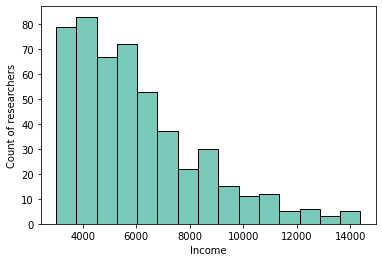

In [10]:
sns.histplot(data['income'], color=colors[0])
plt.xlabel('Income')
plt.ylabel('Count of researchers');

It is usually acceptable to visualise the data distribution and make a judgment call, but it is not acceptable to take, for example, the exact maximum value in the data because doing so would reveal the value of a single data point.

##### True sum

In [11]:
true_sum_income = sum(data['income'])

print("+-----------------------------------------------------+")
print(f"True sum of the researchers' income: {true_sum_income}")
print("+-----------------------------------------------------+")

+-----------------------------------------------------+
True sum of the researchers' income: 3014194
+-----------------------------------------------------+


##### Bounded sum

In [12]:
# setting the clamping bounds 
lower_bound = 6000
upper_bound = 9000

# applying clamping 
# - values less than `lower_bound` will be clipped to `lower_bound` 
# - values greater than `upper_bound` will be clipped to `upper_bound` 
data['bounded_income'] = data['income'].clip(lower=lower_bound, upper=upper_bound)

data[['income', 'bounded_income']].head(10)

,income,bounded_income
0,6527,6527
1,8383,8383
2,8298,8298
3,3763,6000
4,13694,9000
5,3222,6000
6,4095,6000
7,5191,6000
8,7598,7598
9,5310,6000


In [13]:
# computing sum on the bounded values
true_bounded_sum_income = sum(data['bounded_income'])

print("+--------------------------------------------------------------+")
print(f"True bounded sum of the researchers' income: {true_bounded_sum_income}")
print("+--------------------------------------------------------------+")

+--------------------------------------------------------------+
True bounded sum of the researchers' income: 3360366
+--------------------------------------------------------------+


##### Private sum

In [14]:
# sensivity of the sum query in this case is the upper_bound
# reason: maximum the sum query's output will change on adding/removing a row is the `upper_bound`
sensitivity = upper_bound 
epsilon = 0.1

# applying laplacian mechanism
private_sum_income = laplace_mechanism(true_bounded_sum_income, sensitivity, epsilon)

print("+-----------------------------------------------------------------------+")
print(f"Private sum of the researchers's income: {private_sum_income} with error: {percentage_error(true_sum_income, private_sum_income)}%")
print("+-----------------------------------------------------------------------+")

+-----------------------------------------------------------------------+
Private sum of the researchers's income: 3321854.24 with error: 10.21%
+-----------------------------------------------------------------------+


#### 3.3.1. Impact of epsilon <a id="cell331"></a>

Now, we will visualise error with different values of epsilon. 

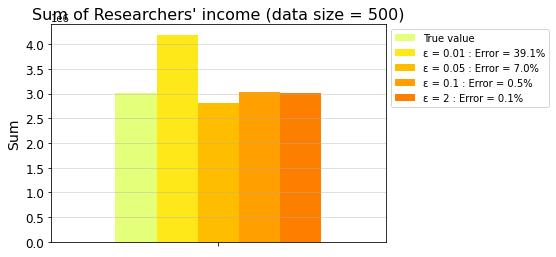

In [15]:
# you can play around with the epsilon values here 
epsilons = [0.01, 0.05, 0.1, 2]

# for visualisation
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_income]

# evaluating on different values of epsilon
for epsilon in epsilons:
    # applying laplace mechanism
    private_sum_income = laplace_mechanism(true_sum_income, sensitivity, epsilon)
    
    dp_results[f"epsilon_{epsilon}"] = [private_sum_income]
    errors.append(percentage_error(true_sum_income, private_sum_income))

# visualise data 
labels = [""]
title = f"Sum of Researchers' income (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (6, 4))

#### 3.3.2. Impact of clamping bounds <a id="cell332"></a>

Now, we will visualise error with different clamping bounds. 

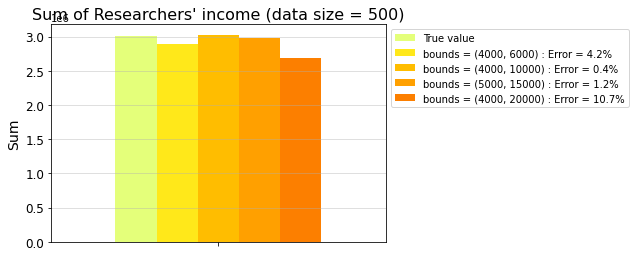

In [16]:
epsilon = 0.1

# you can play around with the clamping bounds here 
bounds = [(4000, 6000), (4000, 10000), (5000, 15000), (4000, 20000)]

# for visualisation
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_income]

# evaluating on different values of clamping bounds
for l, u in bounds:
    # setting sensitivity of the sum query as the `upper_bound`
    sensitivity = u

    # applying clamping 
    data['bounded_income'] = data['income'].clip(lower=l, upper=u)

    # sum of the bounded salaries
    true_bounded_sum_income = sum(data['bounded_income'])
    
    # applying laplace mechanism
    private_sum_income = laplace_mechanism(true_sum_income, sensitivity, epsilon)
    
    dp_results[f"bounds_{str(l)}_{str(u)}"] = [private_sum_income]
    errors.append(percentage_error(true_sum_income, private_sum_income))

# visualise data 
labels = [""]
title = f"Sum of Researchers' income (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, 'bounds', bounds, errors, ylabel, title, labels, (6, 4))

### 3.4. Mean of researchers' income (with post-processing) <a id="cell34"></a>

We might be more interested in the mean income. Fortunately, we already have the differential private releases of the total number of researchers and their income, which we can use to calculate the mean. (Yay! No epsilon spending 😎)

A key feature of differential privacy is **post-processing**, which enables you to perform operations on differentially private releases without jeopardizing their privacy guarantee. The only obvious constraint is that you do not look at the original dataset.  

##### True mean

In [17]:
true_mean_income = true_sum_income/true_count

print("+--------------------------------------------------------+")
print(f"True mean of the researchers's income: {true_mean_income}")
print("+--------------------------------------------------------+")

+--------------------------------------------------------+
True mean of the researchers's income: 6028.388
+--------------------------------------------------------+


##### Private mean

In [18]:
# computing the private mean using the released private sum and count 
private_mean_income = private_sum_income/private_count

print("+----------------------------------------------------------------------------+")
print(f"Private mean of the researchers's income: {private_mean_income} with error: {percentage_error(true_mean_income, private_mean_income)}%")
print("+----------------------------------------------------------------------------+")

+----------------------------------------------------------------------------+
Private mean of the researchers's income: 5382.422900793888 with error: 10.72%
+----------------------------------------------------------------------------+


## Parallel composition 

The aggregates we observed, count, sum, and mean, returned a single statistic for all the data. However, a lot of frequently used data analysis operations are group-by queries, which partition the data into groups and calculate one aggregation per group.


**Parallel composition** is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual’s data appears in exactly one chunk - so even if there are, say, k  chunks in total (and therefore k runs of the mechanism), the mechanism runs exactly once on the data of each individual. 

**So instead of spending a privacy loss of k$\epsilon$ (with sequential composition -- epsilons add up on running multiple queries on a dataset), you only incur a privacy loss of $\epsilon$.** Wow! 😮 

### 3.5. Count of researchers by sector (with parallel composition) <a id="cell35"></a>

We will assume that each researcher belongs to only one sector among Agricultural, Aerospace, Engineering and Healthcare.

Note: If a reseacher belongs to more than one sector than sensivity of the query will increase. Moreover, we need to apply bounds on the maximum sectors a researcher can belong to prevent scaling of the noise. 

##### **True** count of the researchers by sector

In [19]:
true_counts_by_sector = data['sector'].value_counts().to_frame()
true_counts_by_sector

,sector
Aerospace,144
Healthcare,127
Engineering,119
Agricultural,110


##### **Private** count of the researchers by sector

This analysis has a total privacy loss of the set epsilon value (in this case 1), even though we release many results

In [20]:
# sensitivity of the query is 1 
sensitivity = 1 
# setting the epsilon 
epsilon = 1

# applying laplace mechanism
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
# adding noise
private_count_by_sector = data['sector'].value_counts().apply(add_laplace_noise)

private_count_by_sector.to_frame()

,sector
Aerospace,145.03
Healthcare,126.28
Engineering,119.49
Agricultural,109.82


#### Impact of epsilon on the query's output 

In [21]:
true_counts_by_sector_dict = dict(true_counts_by_sector['sector'])

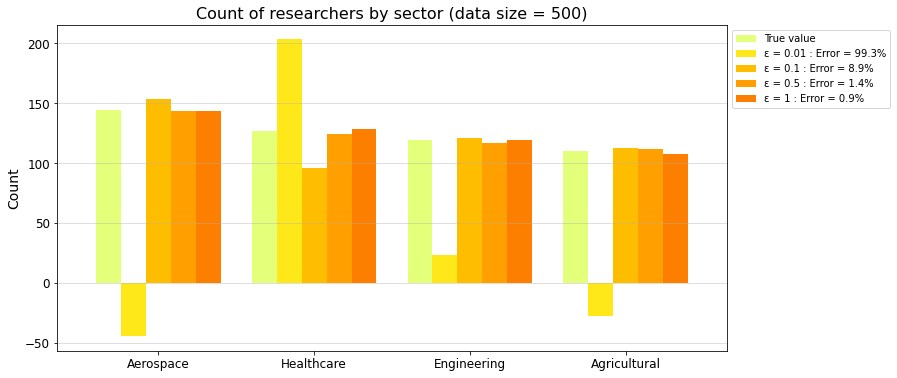

In [22]:
# you can play arround with epsilon values here
epsilons = [0.01, 0.1, 0.5, 1]

# for visualisation
errors = []
dp_results = {}
true_counts_by_sector = true_counts_by_sector_dict.values()
dp_results["true_counts_by_sector"] = true_counts_by_sector
num_sectors = len(true_counts_by_sector)

# evaluating on different values of epsilon
for epsilon in epsilons:
    # applying laplace mechanism
    private_counts_by_sector = [laplace_mechanism(true_count, sensitivity, epsilon) for true_count in true_counts_by_sector]
    
    dp_results[f"epsilon_{epsilon}"] = private_counts_by_sector
    error = sum([percentage_error(tc, pc) for  tc, pc in zip(true_counts_by_sector, private_counts_by_sector)])/num_sectors
    errors.append(error)

# visualise data 
labels = true_counts_by_sector_dict.keys() #["Aerospace", "Agricultural", "Engineering", "Healthcare"]
title = f"Count of researchers by sector (data size = {data_size})"
ylabel = "Count"

visualise(dp_results, 'ε', epsilons, errors, ylabel, title, labels, (12, 6))

### 3.6. Count of researchers by sector and academic degree (with parallel composition) <a id="cell36"></a>

##### **True** count of the researchers by sector and academic degree

In [23]:
pd.crosstab(data['sector'], data['degree'])

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,27,36,27,30,24
Agricultural,20,13,23,28,26
Engineering,22,23,36,23,15
Healthcare,25,25,28,23,26


##### **Private** count of the researchers by sector and academic degree

In [24]:
sensitivity = 1 
epsilon = 0.5

true_count_by_degree_and_sector = pd.crosstab(data['sector'], data['degree'])

# applying laplace mechanism
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
true_count_by_degree_and_sector.applymap(add_laplace_noise)

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,26.72,38.32,27.08,35.84,25.43
Agricultural,19.87,13.68,19.19,27.98,24.59
Engineering,19.28,23.28,53.10,22.67,16.11
Healthcare,23.30,34.34,29.73,20.28,26.52


### 4. Impact of Dataset Size  (TODO) <a id="cell4"></a>

In [27]:
# reading the csv file 
data_10000 = pd.read_csv("data/simulated_data_10000.csv")

data_size = len(data_10000)

print(f"Number of rows in the dataset {data_size}")
data_10000.head(5)

Number of rows in the dataset 10000


,NRIC,researcher_name,sector,income,degree
0,S7212245T,Ernesto Griffin,Aerospace,4876,Non-degree
1,F0642125K,Margaret Mays,Healthcare,6685,Non-degree
2,G2319709V,David Hendryx,Engineering,8337,Masters
3,F4712075F,John Hagens,Agricultural,3504,Masters
4,T5654604E,Michael Shaddix,Engineering,5232,Masters


In [28]:
epsilon = 0.01
bounds = [4000, 12000]
sensitivity = bounds[0]

dataset_sizes = [200, 500, 1000, 10000]

# for visualisation
errors = []
dp_results = {}


for dataset_size in dataset_sizes:
    data_subset = data_10000["income"][:dataset_size]
    
    true_sum = sum(data_subset)
    dp_results["true_sum"] = [true_sum]
    
    # applying clamping 
    data_subset['bounded_income'] = data_subset.clip(lower=bounds[0], upper=bounds[1])
    
    # sum of the bounded salaries
    true_bounded_sum_income = sum(data_subset['bounded_income'])
    
    # applying laplace mechanism
    private_sum_income = laplace_mechanism(true_bounded_sum_income, sensitivity, epsilon)
    
    
    dp_results[f"dataset_size_{dataset_size}"] = [private_sum_income]
    errors.append(percentage_error(true_sum, private_sum_income))
    
    print(dataset_size, true_sum, private_sum_income, percentage_error(true_sum, private_sum_income))

# # visualise data 
# labels = [""]
# title = f"Sum of Researchers' income (data size = {data_size})"
# ylabel = "Sum"
# visualise(dp_results, "dataset_size", dataset_sizes, errors, ylabel, title, labels, (6, 4))

200 1177415 589582.37 49.93
500 2970166 3523500.0 18.63
1000 5966955 6619101.91 10.93
10000 60194596 61045299.8 1.41
